# Notebook to show off as many use cases / edge cases of uncertainty as we can think of (will form basis of pytest module later)

In [1]:
import os
import sys
import pickle
import copy
import numpy as np
import rmgpy.rmg.input  # note this method is currently broken for multiple reactors in an input file
import rmgpy.rmg.main
import rmgpy.chemkin
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties

import rmgpy.tools.canteramodel
import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_i_thing(thing, thing_list):
    for i in range(len(thing_list)):
        if thing.is_isomorphic(thing_list[i]):
            return i
    raise AssertionError(f'Could not find {thing} in list of {len(thing_list)} things')

In [3]:
def pad_to_length(input_str, length):
    input_str = str(input_str)
    if len(input_str) > length:
        print('Pad length for this string must be at least', len(input_str))
        raise ValueError
    return input_str + ' ' * (length - len(input_str))

In [4]:


CH4 = rmgpy.species.Species(smiles='C')
CH3 = rmgpy.species.Species(smiles='[CH3]')
C2H4 = rmgpy.species.Species().from_smiles('C=C')

## Load Mech_02_surf_ethane_lib

In [5]:
# Must use annotated chemkin file
chemkin_file = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/chemkin/chem_annotated-gas.inp'
mech_dir = os.path.dirname(chemkin_file)
surface = os.path.join(mech_dir, 'chem_annotated-surface.inp')
dict_file = os.path.join(mech_dir, 'species_dictionary.txt')
input_file = os.path.join(os.path.dirname(mech_dir), 'input.py')

# Run Gao estimation of input parameters (takes a long time to load database)
uncertainty = rmgpy.tools.uncertainty.Uncertainty(
    output_directory=os.path.join(mech_dir, 'uncertainty'),
    thermo_corr_dir='/home/moon/rmg/RMG-database/input/thermo/uncertainty'
)
uncertainty.load_model(chemkin_file, dict_file, surface_path=surface)

In [6]:
# load the database either copying libraries manually or using the input file
thermo_libs = [
    'surfaceThermoPt111', 'primaryThermoLibrary', 'thermo_DFT_CCSDTF12_BAC', 'DFT_QCI_thermo'
]
kinetics_libs = [
    'O2_dissociative_adsorption',
    'Surface/CPOX_Pt/Deutschmann2006_adjusted',
    'BurkeH2O2inArHe',
]

kinetics_families = [
    'default',
    'Surface_Adsorption_Single',
    'Surface_Adsorption_vdW',
    'Surface_Adsorption_Dissociative',
    'Surface_Dissociation',
    'Surface_Abstraction',
    'Surface_Dissociation_Double_vdW',
    'Surface_Dissociation_vdW',
    'Surface_Abstraction_vdW',
    'Surface_Dissociation_Beta',
    'Surface_Adsorption_Bidentate',
    'Surface_Bidentate_Dissociation',
    'Surface_Monodentate_to_Bidentate',
    'Surface_Dissociation_to_Bidentate', 
    'Surface_vdW_to_Bidentate',
    'Surface_Adsorption_Dissociative_Double',
    'Surface_Abstraction_Beta',
    # 'Surface_Abstraction_Beta_double_vdW',
    'Surface_Dissociation_Double',
    'Surface_Dissociation_Beta_vdW',
    'Surface_Abstraction_Beta_vdW',
    'Surface_Abstraction_Single_vdW',
]


uncertainty.load_database(  # this call does the averaging up of kinetics families
    thermo_libraries=thermo_libs,
    kinetics_families=kinetics_families,
    # kinetics_families=['R_Addition_MultipleBond'],
    reaction_libraries=kinetics_libs,
    # kinetics_depositories=['training'],
)

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2599,68.0494,74.7775,80.9311,90.8846,97.4337,105.393],'J/(mol*K)'), H298=(-477.191,'kJ/mol'), S298=(269.551,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(103.931,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)(Cds-Cd)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Li-OCOdO) + radical(OC=OOJ)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 2000.0 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2599,68.0494,74.7775,80.9311,90.8846,97.4337,105.393],'J/(mol*K)'), H298=(-477.191,'kJ/mol'), S298=(269.551,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(103.931,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)(Cds-Cd)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Li-OCOdO) + radical(OC=OOJ)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for En

### Uncorrelated test cases

In [7]:
# Get the different kinetic and thermo sources
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties()
uncertainty.compile_all_sources()

In [8]:
uncertainty.all_thermo_sources

{'Library': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  48],
 'QM': [],
 'GAV': {},
 'ADS': {'adsorptionPt111': [<Entry index=67 label="C*">]}}

In [9]:
ThermoEngine = rmgpy.tools.uncertainty.ThermoParameterUncertainty()
print('dG_GAV  \t', ThermoEngine.dG_GAV)
print('dG_group\t', ThermoEngine.dG_group)
print('dG_library\t', ThermoEngine.dG_library)
print('dG_surf_lib\t', ThermoEngine.dG_surf_lib)
print('dG_ads_grp\t', ThermoEngine.dG_ADS_group)


dG_GAV  	 1.5
dG_group	 0.3162
dG_library	 1.5
dG_surf_lib	 6.918
dG_ads_grp	 6.918


# See at a glance what kind of species estimates are in the mech

In [10]:
print('Index', '\tSpecies', '\tSources', '\tUncertainty kcal/mol')
print('----------------------------------------------------------')
for i in range(len(uncertainty.species_list)):
    print(i, '\t',
          pad_to_length(uncertainty.species_list[i], 18),
          pad_to_length(set(uncertainty.species_sources_dict[uncertainty.species_list[i]].keys()), 30),
          '\t', f'{uncertainty.thermo_input_uncertainties[i]:.4f}'
         )

Index 	Species 	Sources 	Uncertainty kcal/mol
----------------------------------------------------------
0 	 Ar                 {'Library'}                    	 1.5000
1 	 Ne                 {'Library'}                    	 1.5000
2 	 N2                 {'Library'}                    	 1.5000
3 	 CH4(2)             {'Library'}                    	 1.5000
4 	 O2(3)              {'Library'}                    	 1.5000
5 	 CO2(4)             {'Library'}                    	 1.5000
6 	 H2O(5)             {'Library'}                    	 1.5000
7 	 H2(6)              {'Library'}                    	 1.5000
8 	 CO(7)              {'Library'}                    	 1.5000
9 	 C2H6(8)            {'Library'}                    	 1.5000
10 	 CH2O(9)            {'Library'}                    	 1.5000
11 	 CH3(10)            {'Library'}                    	 1.5000
12 	 C3H8(11)           {'Library'}                    	 1.5000
13 	 H(12)              {'Library'}                    	 1.5000
14 	 C2H5

# Export the covariance matrix

In [11]:
# Get the different kinetic and thermo sources
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties(correlated=True)
uncertainty.compile_all_sources()

In [12]:
cov_G = uncertainty.get_thermo_covariance_matrix()
cov_k = uncertainty.get_kinetic_covariance_matrix()
cov_total = uncertainty.get_overall_covariance_matrix()

Text(0, 0.5, 'Surface Species              Gas Species')

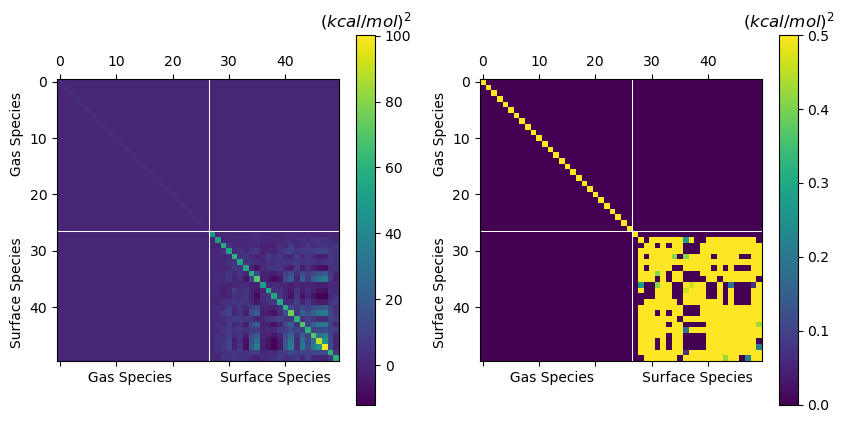

In [13]:
divider = np.argmax([x.contains_surface_site() for x in uncertainty.species_list]) - 0.5

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
mat1 = axs[0].matshow(cov_G)
cb1 = plt.colorbar(mat1, ax=axs[0])
cb1.ax.set_title(r'$(kcal/mol)^2$')

axs[0].axvline(x=divider, color='w', linewidth=0.75)
axs[0].axhline(y=divider, color='w', linewidth=0.75)
axs[0].set_xlabel('     Gas Species           Surface Species')
axs[0].set_ylabel('Surface Species              Gas Species')



mat2 = axs[1].matshow(cov_G)
cb2 = plt.colorbar(mat2, ax=axs[1])
mat2.set_clim([0, 0.5])
cb2.ax.set_title(r'$(kcal/mol)^2$')
axs[1].axvline(x=divider, color='w', linewidth=0.75)
axs[1].axhline(y=divider, color='w', linewidth=0.75)
axs[1].set_xlabel('     Gas Species           Surface Species')
axs[1].set_ylabel('Surface Species              Gas Species')

# kinetics cov

Text(0, 0.5, 'Surface Reactions              Gas Reactions')

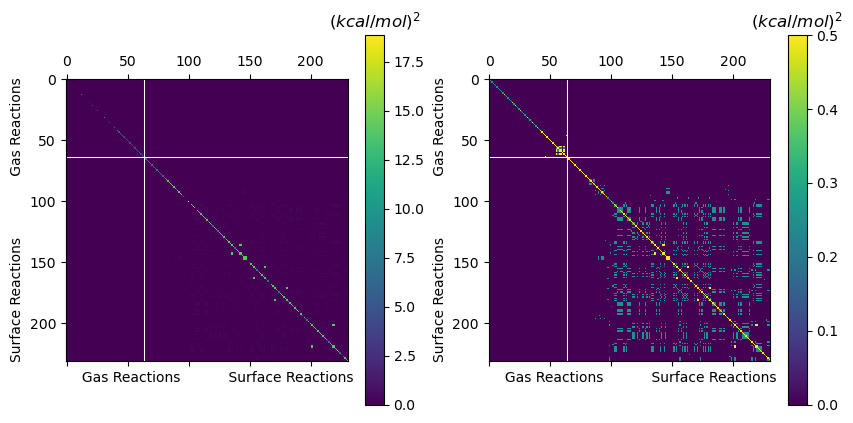

In [14]:
divider = np.argmax([x.is_surface_reaction() for x in uncertainty.reaction_list]) - 0.5

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
mat1 = axs[0].matshow(cov_k)
cb1 = plt.colorbar(mat1, ax=axs[0])
cb1.ax.set_title(r'$(kcal/mol)^2$')
axs[0].axvline(x=divider, color='w', linewidth=0.75)
axs[0].axhline(y=divider, color='w', linewidth=0.75)
axs[0].set_xlabel('     Gas Reactions           Surface Reactions')
axs[0].set_ylabel('Surface Reactions              Gas Reactions')



mat2 = axs[1].matshow(cov_k)
cb2 = plt.colorbar(mat2, ax=axs[1])
mat2.set_clim([0, 0.5])
cb2.ax.set_title(r'$(kcal/mol)^2$')
axs[1].axvline(x=divider, color='w', linewidth=0.75)
axs[1].axhline(y=divider, color='w', linewidth=0.75)
axs[1].set_xlabel('     Gas Reactions           Surface Reactions')
axs[1].set_ylabel('Surface Reactions              Gas Reactions')

# Overall cov

Text(0, 0.5, 'Surface Reactions              Gas Reactions')

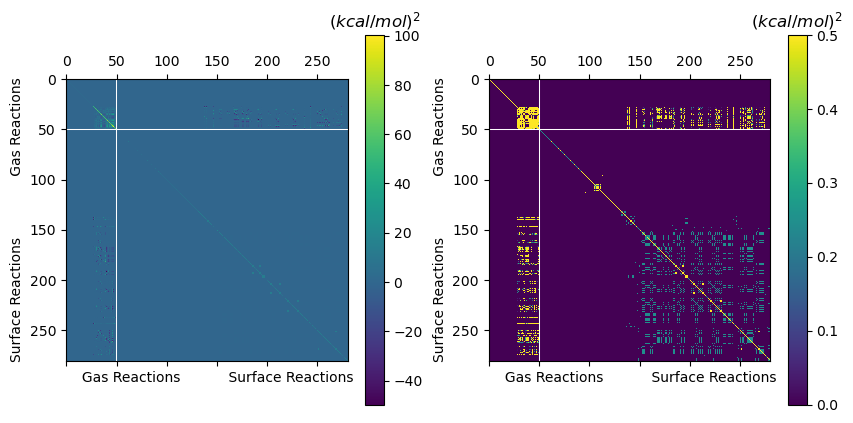

In [15]:
divider = len(uncertainty.species_list) - 0.5

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
mat1 = axs[0].matshow(cov_total)
cb1 = plt.colorbar(mat1, ax=axs[0])
cb1.ax.set_title(r'$(kcal/mol)^2$')
axs[0].axvline(x=divider, color='w', linewidth=0.75)
axs[0].axhline(y=divider, color='w', linewidth=0.75)
axs[0].set_xlabel('     Gas Reactions           Surface Reactions')
axs[0].set_ylabel('Surface Reactions              Gas Reactions')



mat2 = axs[1].matshow(cov_total)
cb2 = plt.colorbar(mat2, ax=axs[1])
mat2.set_clim([0, 0.5])
cb2.ax.set_title(r'$(kcal/mol)^2$')
axs[1].axvline(x=divider, color='w', linewidth=0.75)
axs[1].axhline(y=divider, color='w', linewidth=0.75)
axs[1].set_xlabel('     Gas Reactions           Surface Reactions')
axs[1].set_ylabel('Surface Reactions              Gas Reactions')

In [16]:
# save files

np.save(os.path.join(mech_dir, 'cov_G_kcal2_mol2.npy'), cov_G)
np.save(os.path.join(mech_dir, 'cov_k.npy'), cov_k)
np.save(os.path.join(mech_dir, 'cov_total.npy'), cov_total)